# INFO 450 – FEMA Disaster Relief Effectiveness Project
**Name:** Claytis Egbulem  
**Course:** INFO 450  
**Dataset:** FEMA Individual Assistance – Sample (fema_sample.csv)

---

This notebook analyzes FEMA disaster relief data to:

- Explore TSA eligibility patterns
- Evaluate equity across income levels and residence types
- Conduct inferential statistics (95% CI and t-tests)
- Build Decision Tree & Random Forest models
- Support an interactive Streamlit dashboard


## 1. Setup and Data Loading


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

plt.rcParams["figure.figsize"] = (10, 5)

# Load FEMA sample file
df = pd.read_csv("fema_sample.csv")

df.head()


,disasterNumber,damagedCity,damagedStateAbbreviation,damagedZipCode,householdComposition,grossIncome,specialNeeds,ownRent,residenceType,homeOwnersInsurance,...,rentalAssistanceEndDate,rentalResourceCity,rentalResourceStateAbbreviation,rentalResourceZipCode,primaryResidence,personalPropertyEligible,ppfvl,censusBlockId,id,censusYear
0,4337,OPALOCKA,FL,33055.0,1,8000.0,0,Renter,Apartment,0,...,NaN,NaN,NaN,NaN,1.0,1,341.7,1.208601e+14,7a1665b0-1103-4ee4-bbf9-139d2549cfc8,2010.0
1,4337,WINTER PARK,FL,32792.0,4,50150.0,0,Renter,Condo,0,...,NaN,NaN,NaN,NaN,1.0,0,NaN,1.209502e+14,2c609b27-73ff-4fec-ac28-1aa4f48e1aa0,2010.0
2,4339,YABUCOA,PR,767.0,4,4800.0,0,Renter,Apartment,0,...,NaN,NaN,NaN,NaN,1.0,0,NaN,7.215195e+14,61dd6bb7-554e-4b57-80a2-ae94c61e0f78,2010.0
3,4339,CAROLINA,PR,987.0,1,0.0,0,Owner,House/Duplex,0,...,NaN,NaN,NaN,NaN,1.0,1,3337.9,7.203105e+14,5fc89e40-b1e3-4c62-b3c4-db437447f5db,2010.0
4,4337,NAPLES,FL,34116.0,1,37000.0,0,Owner,Condo,1,...,NaN,NaN,NaN,NaN,1.0,0,NaN,1.202101e+14,48ee3990-4dac-4758-8c3f-ec07845e4348,2010.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Part I – Exploratory Data Analysis (EDA)

Goals:
- Handle missing values
- Crosstab analysis
- Groupby summaries
- Required charts (4 total)


### 2.1 Handling Missing Values


In [4]:
data = df.copy()

# Drop missing key variables
data = data.dropna(subset=["repairAmount", "tsaEligible"])

data.isna().sum()


,0
disasterNumber,0
damagedCity,0
damagedStateAbbreviation,0
damagedZipCode,0
householdComposition,0
grossIncome,4993
specialNeeds,0
ownRent,0
residenceType,0
homeOwnersInsurance,0


### 2.2 TSA Eligibility by Residence Type and State (pd.crosstab)


In [5]:
crosstab_result = pd.crosstab(
    data["residenceType"],
    data["damagedStateAbbreviation"],
    values=data["tsaEligible"],
    aggfunc="mean"
)

crosstab_result


damagedStateAbbreviation,FL,LA,NC,PR,TX
residenceType,,,,,
Apartment,0.285714,0.000000,0.000000,0.982249,0.333333
Boat,0.804878,0.200000,NaN,1.000000,0.714286
Condo,0.387387,0.200000,0.000000,0.968750,0.682927
House/Duplex,0.255244,0.166590,0.048780,0.952038,0.506025
Mobile Home,0.298185,0.152124,0.062738,1.000000,0.406977
Other,0.333333,0.000000,0.000000,0.904762,0.625000
Townhouse,0.253333,0.187500,NaN,0.986622,0.719101
Travel Trailer,0.564103,0.111888,0.100000,1.000000,0.553571


### 2.3 Average Repair Amount by State (groupby)


In [6]:
avg_repair = (
    data.groupby("damagedStateAbbreviation")["repairAmount"]
    .mean()
    .sort_values(ascending=False)
)

avg_repair.head(15)


,repairAmount
damagedStateAbbreviation,
TX,8427.959808
LA,6739.833088
NC,4722.557016
FL,4036.196742
PR,3467.899649


### 2.4 Required Charts


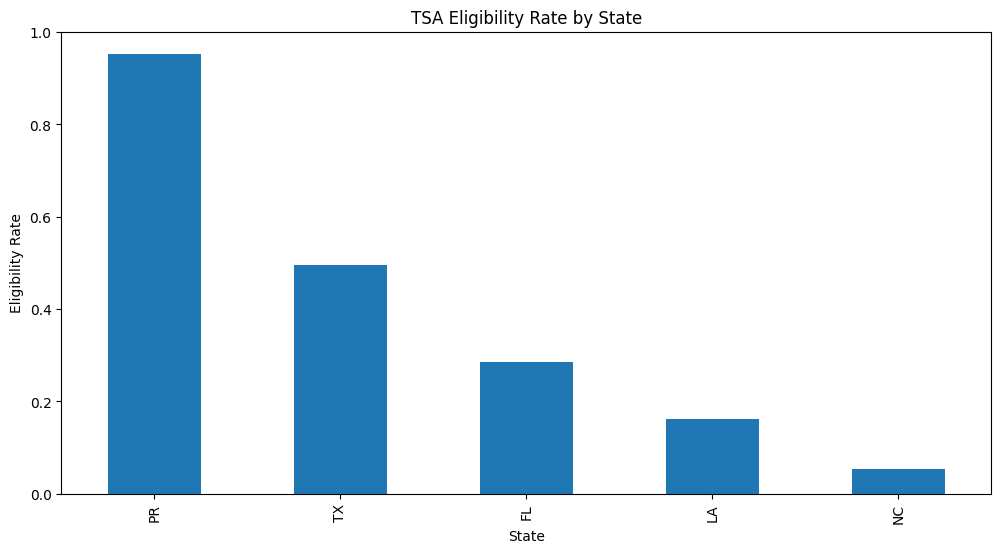

In [7]:
tsa_rate = (
    data.groupby("damagedStateAbbreviation")["tsaEligible"]
    .mean()
    .sort_values(ascending=False)
)

tsa_rate.plot(kind="bar", figsize=(12,6))
plt.title("TSA Eligibility Rate by State")
plt.xlabel("State")
plt.ylabel("Eligibility Rate")
plt.show()


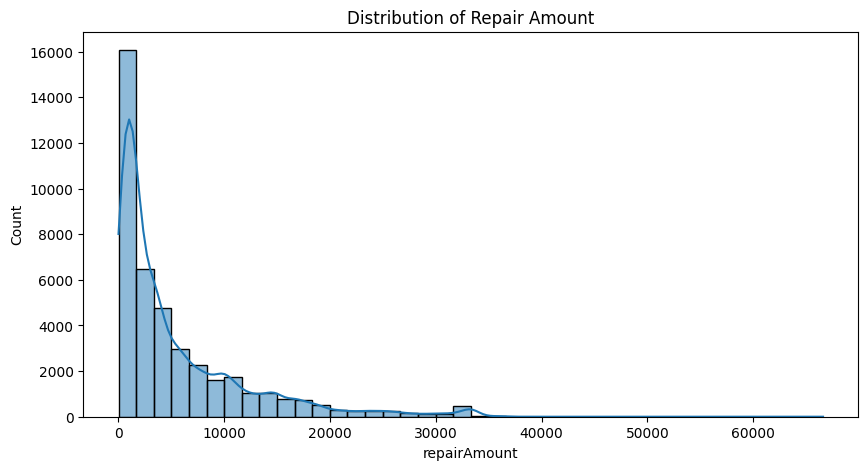

In [8]:
sns.histplot(data["repairAmount"], bins=40, kde=True)
plt.title("Distribution of Repair Amount")
plt.show()


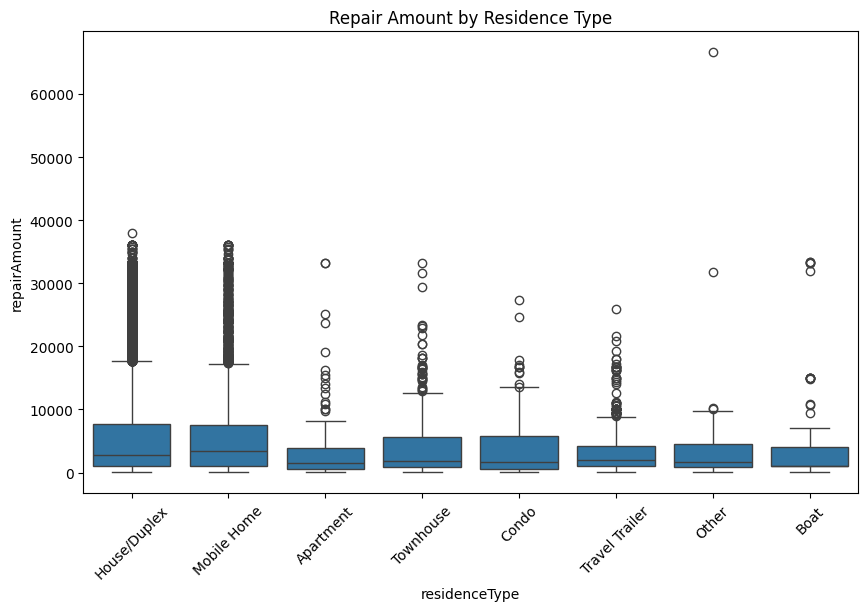

In [9]:
plt.figure(figsize=(10,6))
sns.boxplot(data=data, x="residenceType", y="repairAmount")
plt.title("Repair Amount by Residence Type")
plt.xticks(rotation=45)
plt.show()


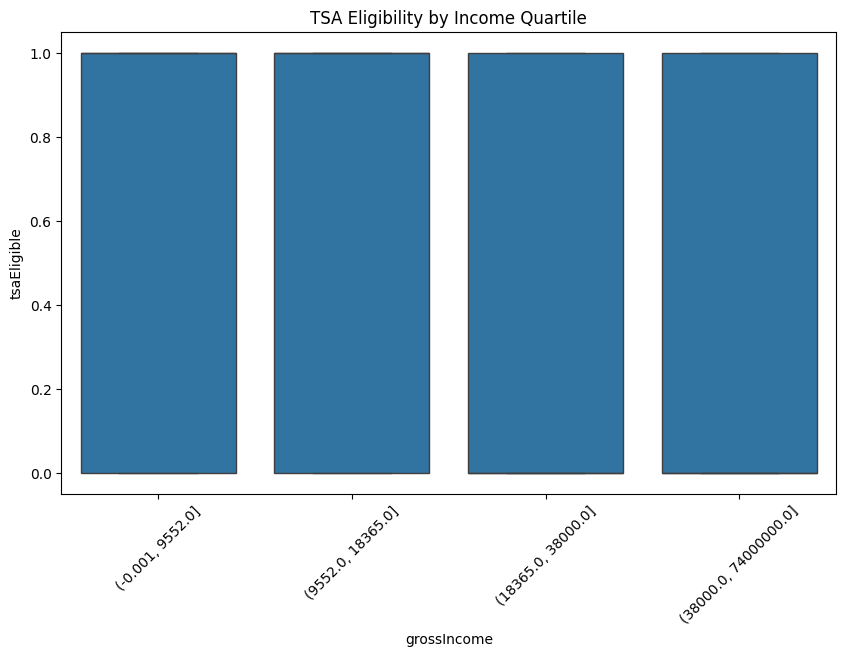

In [10]:
income_bins = pd.qcut(data["grossIncome"], 4, duplicates="drop")

plt.figure(figsize=(10,6))
sns.boxplot(x=income_bins, y=data["tsaEligible"])
plt.title("TSA Eligibility by Income Quartile")
plt.xticks(rotation=45)
plt.show()


## 3. Part II – Inferential Statistics

Goals:
- 95% Confidence Intervals
- Compare two states
- Two-sample t-test


### 3.1 Confidence Interval Function


In [11]:
def ci(sample):
    sample = sample.dropna()
    mean = np.mean(sample)
    sem = stats.sem(sample)
    ci_low, ci_high = stats.t.interval(0.95, len(sample)-1, loc=mean, scale=sem)
    return mean, ci_low, ci_high


### 3.2 CI: TSA Eligible vs Non-Eligible


In [12]:
tsa_yes = data[data["tsaEligible"] == 1]["repairAmount"]
tsa_no  = data[data["tsaEligible"] == 0]["repairAmount"]

print("TSA Eligible:", ci(tsa_yes))
print("Not Eligible:", ci(tsa_no))


TSA Eligible: (np.float64(5928.734796571191), np.float64(5836.960513280495), np.float64(6020.509079861886))
Not Eligible: (np.float64(4871.448909293267), np.float64(4788.272766509597), np.float64(4954.625052076937))


### 3.3 CI and t-test for Two States (Example: TX vs FL)


In [13]:
state1 = data[data["damagedStateAbbreviation"] == "TX"]["repairAmount"]
state2 = data[data["damagedStateAbbreviation"] == "FL"]["repairAmount"]

print("TX CI:", ci(state1))
print("FL CI:", ci(state2))

t_stat, p_val = stats.ttest_ind(state1, state2, equal_var=False)
t_stat, p_val


TX CI: (np.float64(8427.959807574563), np.float64(8278.79461439731), np.float64(8577.125000751817))
FL CI: (np.float64(4036.1967419407624), np.float64(3901.185620142286), np.float64(4171.207863739239))


(np.float64(42.7897852898557), np.float64(0.0))

## 4. Part III – Predictive Modeling


### 4.1 Feature Selection and Preprocessing


In [14]:
model_data = data[[
    "tsaEligible",
    "grossIncome",
    "repairAmount",
    "destroyed",
    "waterLevel",
    "residenceType",
    "damagedStateAbbreviation"
]].dropna()

X = model_data.drop("tsaEligible", axis=1)
y = model_data["tsaEligible"]

num_cols = ["grossIncome", "repairAmount", "waterLevel"]
cat_cols = ["destroyed", "residenceType", "damagedStateAbbreviation"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)


### 4.2 Train/Test Split


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### 4.3 Decision Tree Classifier


In [16]:
dt_model = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(max_depth=4, random_state=42))
])

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))


Decision Tree Accuracy: 0.8526701002981838
Precision: 0.8941560070228242
Recall: 0.8427895981087471
[[2726  422]
 [ 665 3565]]


### 4.4 Random Forest Classifier


In [17]:
rf_model = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.8307129303334236
Precision: 0.8522807846844718
Recall: 0.8524822695035461
[[2523  625]
 [ 624 3606]]


In [18]:
import pandas as pd

# Load your large sample CSV
df = pd.read_csv("fema_sample.csv", low_memory=False)

# Create a clean random sample of 10,000 rows
small = df.sample(n=10000, random_state=42)

# Save the clean sample CSV
small.to_csv("fema_small.csv", index=False)

print("Done! Clean CSV created:", small.shape)


Done! Clean CSV created: (10000, 42)
